# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install phik -q

In [2]:
!pip install --upgrade scikit-learn -q

In [4]:
!pip install shap -q

In [5]:
!pip install lightgbm --upgrade -q

In [6]:
!pip install category_encoders -q

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import phik
import math
import shap
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from phik import resources, report
from phik.report import plot_correlation_matrix
from scipy import stats as st
from scipy.stats import randint, mode
from math import sqrt
from math import factorial
from matplotlib import pyplot as plt
from scipy.stats import binom, norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from category_encoders import BinaryEncoder
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    accuracy_score, 
    r2_score, 
    mean_squared_error, 
    mean_absolute_error,
    roc_auc_score,
    make_scorer,
    f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
#from imblearn.over_sampling import SMOTE

In [8]:
data_autos = pd.read_csv('/datasets/autos.csv', sep = ',', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [9]:
def inf(df, r):
    df1=df.head(r)
    df2=df.info()
    return display(df1, df2)

In [10]:
inf(data_autos, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


None

**Данные загружены, соответствуют описанию, типы данных в порядке. Имеются пропуски в данных.**

In [12]:
data_autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Обработаем пропуски.**

**Пропуски в наименованиях модели заменим на 'unknown'**

**Пропуски в `Repaired` также заменим на 'unknown'**

**Тип кузова заполним по наиболее распространенным значеним в сочетании марки и модели машины.**

**Тип коробки передач и тип топлива заполним аналогично типу кузова, по наиболее распространенным среди машин данной марки и модели.**

In [13]:
data_autos['Model'] = data_autos['Model'].fillna('unknown')

In [14]:
data_autos['Repaired'] = data_autos['Repaired'].fillna('unknown')

In [15]:
def most_commons (col):
    most_com = data_autos.groupby(['Model', 'Brand'])[col].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    data_autos[col] = data_autos[col].fillna(most_com)

In [16]:
most_commons ('VehicleType')

In [17]:
most_commons ('Gearbox')

In [18]:
most_commons ('FuelType')

In [19]:
data_autos.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

**Проверим данные на дубликаты и удалим их, в случае наличия.**

In [20]:
data_autos.duplicated().sum()

4

In [21]:
data_autos = data_autos.drop_duplicates(keep='first')
data_autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

**Предобработка закончена, проведём исследовательский анализ данных.**

In [22]:
data_autos.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [23]:
inf(data_autos, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  NumberOfPictures   354365 non-null  int64   

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,unknown,2016-03-17,0,27472,2016-03-31 17:17:06


None

In [24]:
g1_hist = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'NumberOfPictures', 'PostalCode']
g2_hist = ['Цена (евро)', 'Тип автомобильного кузова', 'Год регистрации автомобиля', 'Тип коробки передач',
           'Мощность (л. с.)', 'Модель автомобиля', 'Пробег (км)', 'Месяц регистрации автомобиля',
           'Тип топлива', 'Марка автомобиля', 'Была ли машина в ремонте', 'Количество фотографий автомобиля',
           'Почтовый индекс владельца анкеты']
bins_hist = [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]

In [25]:
def hist_1(g1_hist, g2_hist, bins_hist, data_autos):
    for n in range(len(g1_hist)):
        discr_sign = ['RegistrationMonth', 'NumberOfPictures', 'PostalCode']

        if pd.api.types.is_numeric_dtype(data_autos[g1_hist[n]]) and (g1_hist[n] not in discr_sign):
            fig, ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6))
            ax[0].hist(data_autos[g1_hist[n]], bins=bins_hist[n], alpha=0.5, edgecolor='red')
            ax[0].set_title(f'Гистограмма и "ящик с усами" для признака \n{g2_hist[n]}', fontsize=14)
            ax[0].set_ylabel('Количество', fontsize=12)
            ax[0].grid(True)
            
            ax[1].boxplot(data_autos[g1_hist[n]], vert=False, widths=0.7, positions=[1], patch_artist=True, boxprops=dict(facecolor='red', color='red'))
            ax[1].set_xlabel(f'{g2_hist[n]}', fontsize=12)
            ax[1].set_yticks([1])
            
        elif pd.api.types.is_numeric_dtype(data_autos[g1_hist[n]]) and (g1_hist[n] in discr_sign):
            fig, ax = plt.subplots(figsize=(8,6))
            sns.countplot(x=data_autos[g1_hist[n]], ax=ax, color='red', alpha=0.5)
            ax.set_title(f'Диаграмма для признака \n{g2_hist[n]}', fontsize=14)
            ax.set_ylabel('Количество', fontsize=12)
            ax.set_xlabel(f'{g2_hist[n]}', fontsize=12)
            ax.grid(True)
                  

        else:

            fig, ax = plt.subplots(figsize=(12,6))
            value_counts = data_autos[g1_hist[n]].value_counts(normalize=True)
            wedges, texts = ax.pie(value_counts, startangle=90)
            ax.set_title(f'{g2_hist[n]}', fontsize=12)
            legend_labels = [f'{label}: {percent:.1f}%' for label, percent in zip(value_counts.index, value_counts * 100)]
            ax.legend(wedges, legend_labels, title="Категории", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
            
        plt.tight_layout()
        plt.show()

        display(data_autos[g1_hist[n]].describe(include='all'))
        print(80*'*')

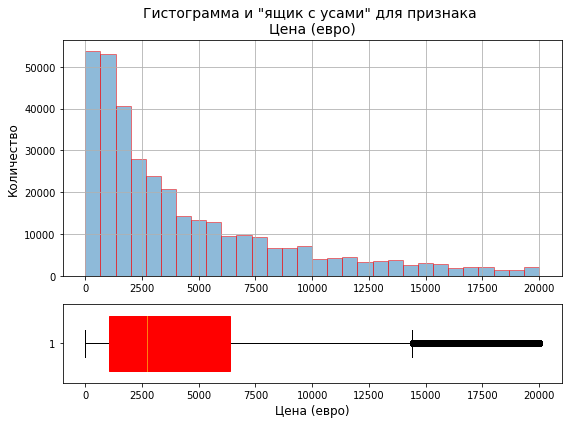

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

********************************************************************************


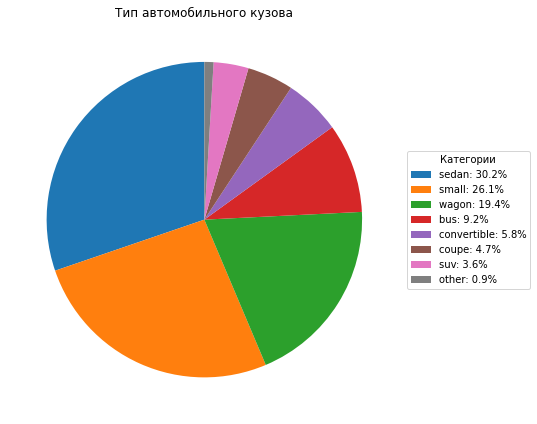

count     354365
unique         8
top        sedan
freq      107178
Name: VehicleType, dtype: object

********************************************************************************


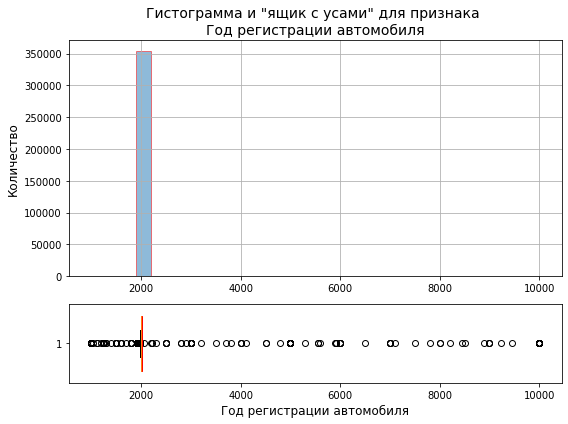

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

********************************************************************************


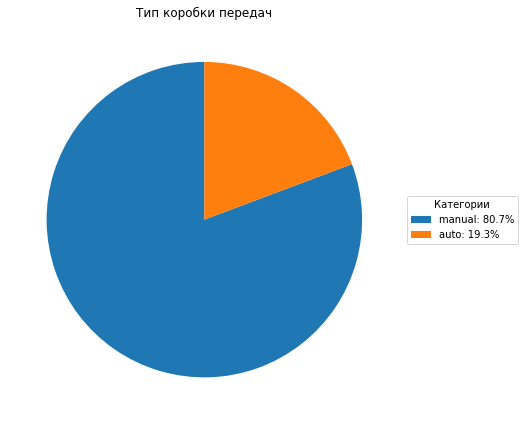

count     354365
unique         2
top       manual
freq      286049
Name: Gearbox, dtype: object

********************************************************************************


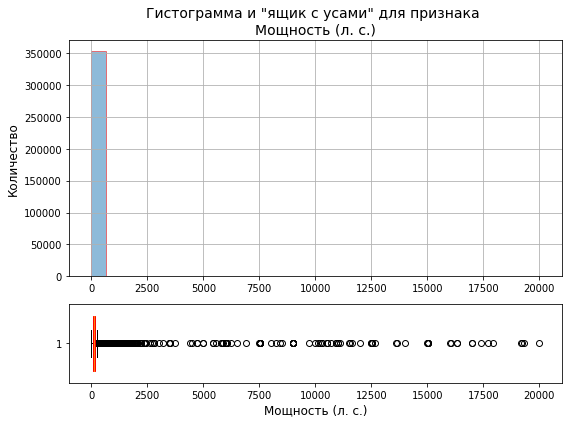

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

********************************************************************************


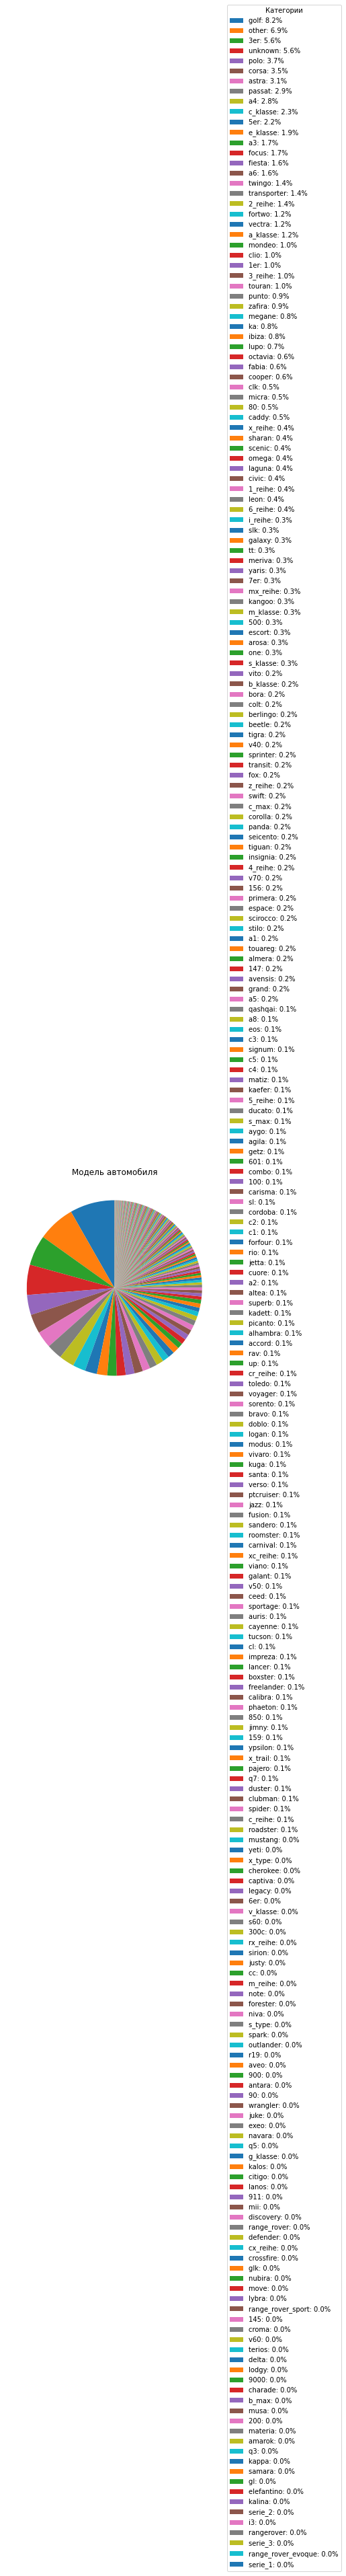

count     354365
unique       251
top         golf
freq       29232
Name: Model, dtype: object

********************************************************************************


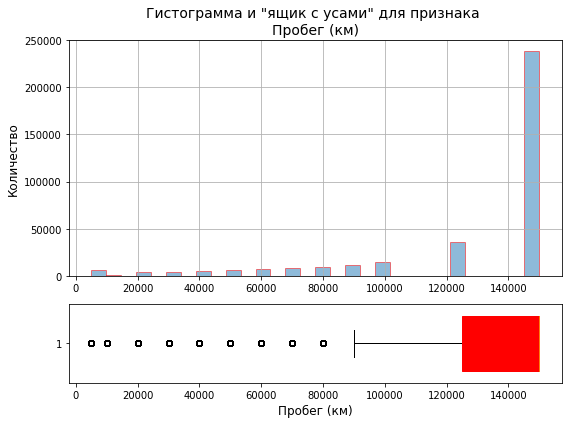

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

********************************************************************************


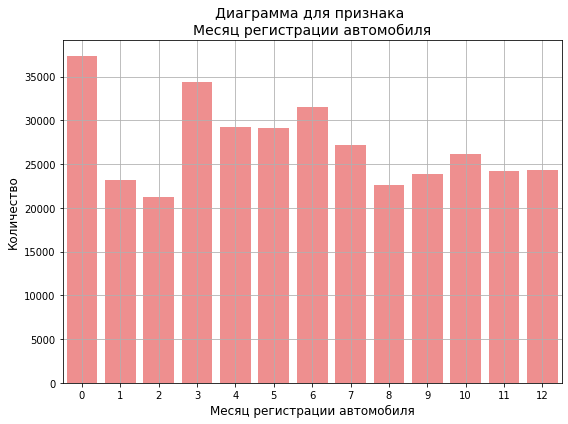

count    354365.000000
mean          5.714650
std           3.726432
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

********************************************************************************


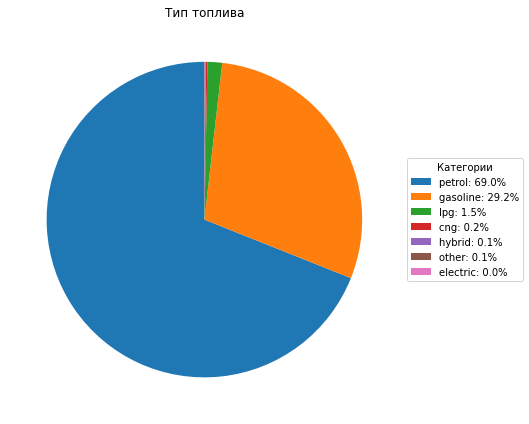

count     354365
unique         7
top       petrol
freq      244341
Name: FuelType, dtype: object

********************************************************************************


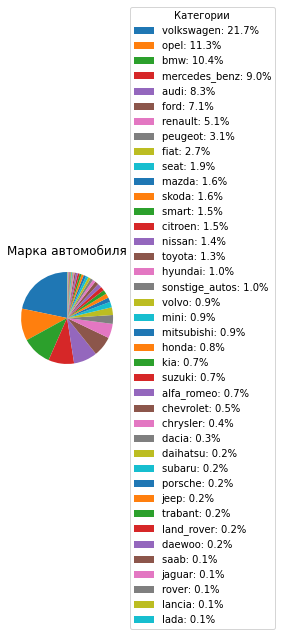

count         354365
unique            40
top       volkswagen
freq           77012
Name: Brand, dtype: object

********************************************************************************


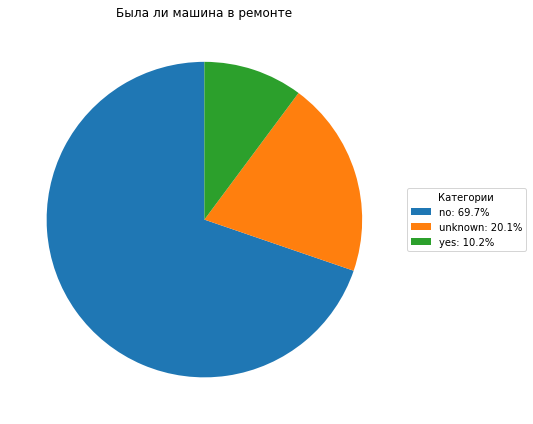

count     354365
unique         3
top           no
freq      247158
Name: Repaired, dtype: object

********************************************************************************


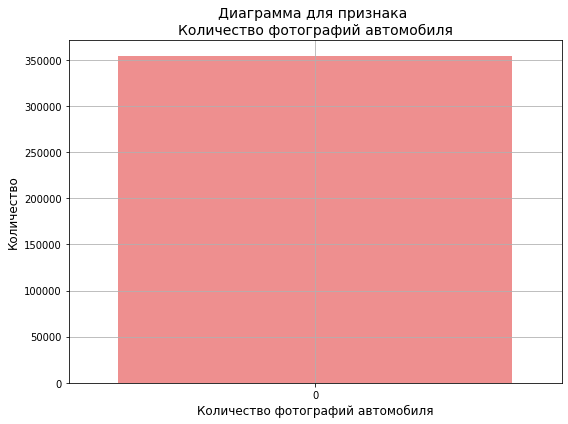

count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

********************************************************************************


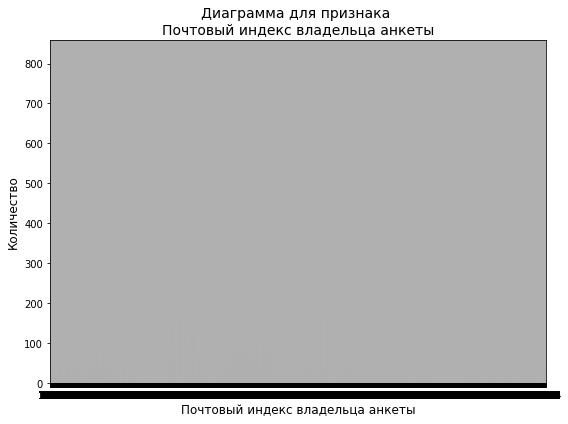

count    354365.000000
mean      50508.503800
std       25783.100078
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64

********************************************************************************


In [26]:
hist_1(g1_hist, g2_hist, bins_hist, data_autos)

In [27]:
g1_hist_d=['DateCrawled', 'DateCreated', 'LastSeen']
g2_hist_d = ['Дата скачивания анкеты из базы', 'Дата создания анкеты', 'Дата последней активности пользователя']
bins_hist_d = [60, 60, 60]

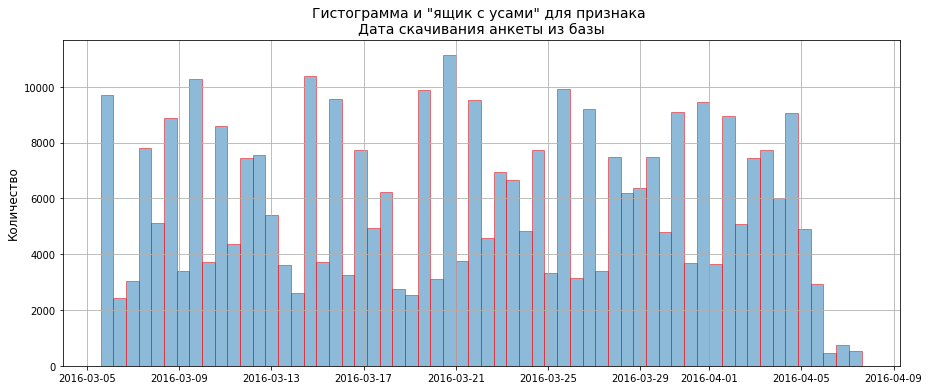

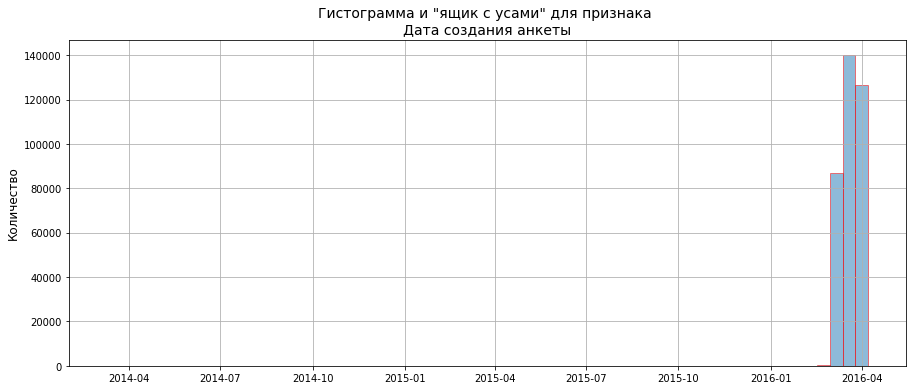

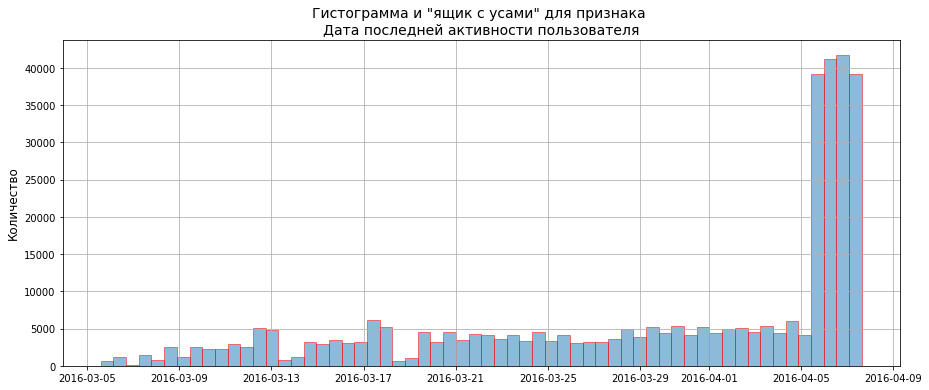

In [28]:
for n in range(len(g1_hist_d)):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
    ax.hist(data_autos[g1_hist_d[n]], bins=bins_hist_d[n], alpha=0.5, edgecolor='red')
    ax.set_title(f'Гистограмма и "ящик с усами" для признака \n{g2_hist_d[n]}', fontsize=14)
    ax.set_ylabel('Количество', fontsize=12)
    ax.grid(True)

    plt.show()

In [29]:
data_autos['DateCreated'].max()

Timestamp('2016-04-07 00:00:00')

**По диаграммам можем отметить следующее:**
- Гистограмма по цене имеет вид распределения Пуассона с пиком около 0. Большая доля цен сосредоточена в нижнем диапазоне, однако разброс цен очень большой, и вследствие наличия высоких значений наблюдаем, что среднее и медианные значения довольно сильно различаются и стандартное отклонение довольно высокое. Ящик с усами показывает выбросы, однако цены правдоподобны, поэтому оставим эти значения.
- По круговой диаграмме типов автомобильного кузова видим наибольшую распространенность кузова типа sedan.
- По гистограмме года регистрации автомобиля видим наличие выбросов, неправдоподобных значений. Удалим строки с годом менее 1950 (автомобили более раннего года если и встречаются, то штучно и в качестве раритета, на который стандартные подходы к прогнозу цен не будут работать) и с годом более 2016, так как выгрузка ограничена этим годом.
- Коробка передач превалирует ручная (manual)
- По мощности видим выбросы, аномальные значения. Оставим значения до 1000 л.с., остальные удалим.
- По круговой диаграмме видим очень большой перечень моделей. Наибольшую долю занимает golf.
- Гистограмма по пробегу имеет вид распределения Пуассона с пиком около 150000 км, именно в этих значениях сосредоточено наибольшее количество объявлений. Среднее и медианные значения различаются не очень сильно, стандартное отклонение умеренное. Ящик с усами показывает выбросы, однако значения пробега правдоподобны, поэтому оставим их.
- По месяцам регистрации распределение довольно равномерное, при этом видим большое количество значений 0, что вероятно связано либо с ошибкой, либо просто с отсутствием данных.
- По типу топлива видим, что наибольшую долю занимает бензин (petrol).
- По маркам автомобиля видим лидерство за Volkswagen (21,7%).
- 69,7% машин заявляются, как не бывщие в ремонте. При этом по большой доле (20%) данные отсутствуют.
- Абсолютно по всем объявлениям отсутствуют фотографии автомобиля.
- Даты скачивания анкеты распределены равномерно
- Даты создания анкеты сосредоточены в диапазоне март-апрель 2016 года, а также в малом количестве в более ранние периоды, до 2014 года
- Даты последней активности пользователя сосредоточены в диапазоне 6-7 апреля 2016 года, а также в малом количестве в более ранние даты, до 5 марта 2016 года

**Также можем отметить неинформативный признак `NumberOfPictures` (количество фотографий автомобиля), его можно удалить.**

In [30]:
data_autos = data_autos.query('1950<=RegistrationYear<=2016 and Power<1000')

In [32]:
data_autos = data_autos.drop('NumberOfPictures', axis=1)

In [33]:
data_autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [34]:
g1_hist = ['RegistrationYear', 'Power']
g2_hist = ['Год регистрации автомобиля', 'Мощность (л. с.)']
bins_hist = [76, 30]

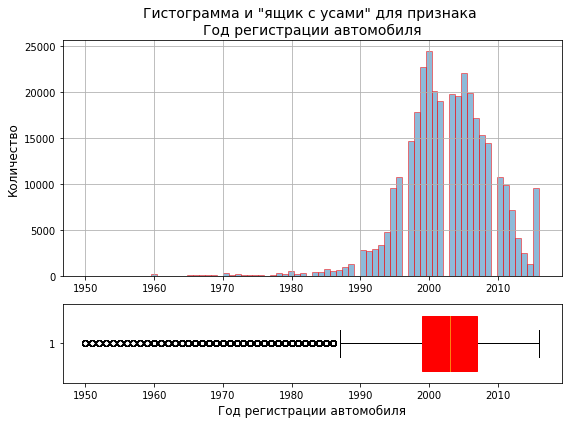

count    339309.000000
mean       2002.526211
std           6.835480
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

********************************************************************************


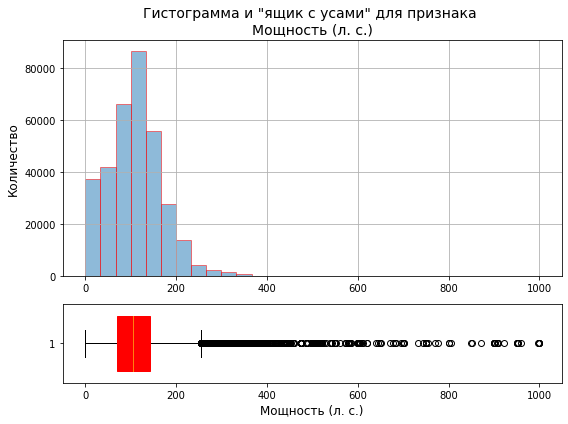

count    339309.000000
mean        107.727378
std          63.859426
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max         999.000000
Name: Power, dtype: float64

********************************************************************************


In [35]:
hist_1(g1_hist, g2_hist, bins_hist, data_autos)

**После удаления аномалий видим:**
- Гистограмма по году регистрации имеет вид распределения Пуассона с пиком около 2000 года. Среднее и медианные значения близки, стандартное отклонение небольшое. 
- Гистограмма по мощности имеет вид распределения Пуассона с пиком около 100 л.с. Среднее и медианные значения близки, стандартное отклонение довольно большое. 

In [36]:
data_autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339309 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        339309 non-null  datetime64[ns]
 1   Price              339309 non-null  int64         
 2   VehicleType        339309 non-null  object        
 3   RegistrationYear   339309 non-null  int64         
 4   Gearbox            339309 non-null  object        
 5   Power              339309 non-null  int64         
 6   Model              339309 non-null  object        
 7   Kilometer          339309 non-null  int64         
 8   RegistrationMonth  339309 non-null  int64         
 9   FuelType           339309 non-null  object        
 10  Brand              339309 non-null  object        
 11  Repaired           339309 non-null  object        
 12  DateCreated        339309 non-null  datetime64[ns]
 13  PostalCode         339309 non-null  int64   

**После удалений аномалий, потеряно менее 5% данных, что является для нас допустимым.**

**Судя по почтовому индексам данные относятся к Германии. В почтовом индексе Германии код региона заложен в первых 2 цифрах, он нам более ценен, чем конкретное почтовое отделение. Извлечем их в отдельный столбце и удалим почтовый индекс.**

In [37]:
data_autos['Region'] = data_autos['PostalCode'].astype(str).str[:2].astype(int)
data_autos = data_autos.drop('PostalCode', axis=1)

**Построим матрицу корреляций Phik.**

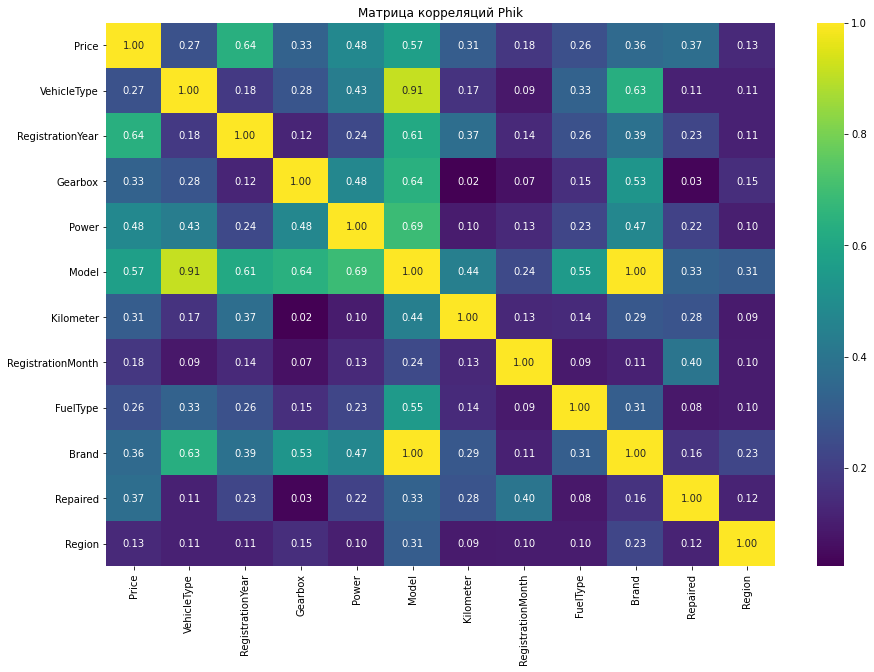

In [38]:
phik_cols = ['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'Region']
phik_corr_matrix = (data_autos[phik_cols]
                    .phik_matrix(interval_cols= ['Price', 'RegistrationYear', 
       'Power', 'Kilometer'])
)
plt.figure(figsize=(15, 10))
sns.heatmap(phik_corr_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Матрица корреляций Phik')
plt.show()

**По матрице корреляций видим сильную зависимость целевого признака (Price) от года регистрации автомобиля, модели и мощности, а также умеренную зависимость от типа автомобильного кузова, типа коробки передач, пробега, бренда, наличия ремонта и индекса пользователя.**

**Также наблюдаем очень высокую корреляцию между моделью и типом кузова (0.91), а также маркой автомобиля (1.0), что говорит о наличии мультиколлинеарности. Объединим колонки с брендом, моделью и типом кузова в одну.**

In [39]:
data_autos['Model']=data_autos['Brand']+ ' ' + data_autos['Model']+ ' ' + data_autos['VehicleType']
data_autos = data_autos.drop(['Brand', 'VehicleType'], axis=1)

In [40]:
data_autos.head()

,DateCrawled,Price,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Repaired,DateCreated,LastSeen,Region
0,2016-03-24 11:52:17,480,1993,manual,0,volkswagen golf sedan,150000,0,petrol,unknown,2016-03-24,2016-04-07 03:16:57,70
1,2016-03-24 10:58:45,18300,2011,manual,190,audi unknown coupe,125000,5,gasoline,yes,2016-03-24,2016-04-07 01:46:50,66
2,2016-03-14 12:52:21,9800,2004,auto,163,jeep grand suv,125000,8,gasoline,unknown,2016-03-14,2016-04-05 12:47:46,90
3,2016-03-17 16:54:04,1500,2001,manual,75,volkswagen golf small,150000,6,petrol,no,2016-03-17,2016-03-17 17:40:17,91
4,2016-03-31 17:25:20,3600,2008,manual,69,skoda fabia small,90000,7,gasoline,no,2016-03-31,2016-04-06 10:17:21,60


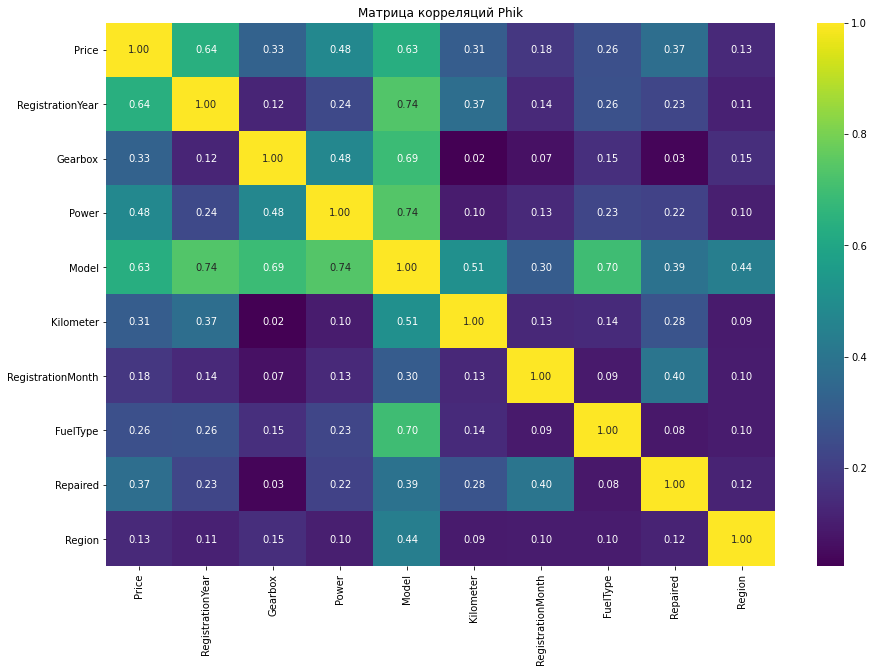

In [41]:
phik_cols = ['Price', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 
       'Repaired', 'Region']
phik_corr_matrix = (data_autos[phik_cols]
                    .phik_matrix(interval_cols= ['Price', 'RegistrationYear', 
       'Power', 'Kilometer'])
)
plt.figure(figsize=(15, 10))
sns.heatmap(phik_corr_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Матрица корреляций Phik')
plt.show()

In [42]:
data_autos.columns

Index(['DateCrawled', 'Price', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Repaired', 'DateCreated',
       'LastSeen', 'Region'],
      dtype='object')

In [43]:
data_autos = data_autos.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis=1)

## Обучение моделей

In [45]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#label_encoder = LabelEncoder()
#data_autos['Price'] = label_encoder.fit_transform(data_autos['Price'])

X_train, X_test, y_train, y_test = train_test_split(
    data_autos.drop(columns=['Price'], axis=1),
    data_autos['Price'],
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

be_columns = ['Gearbox', 'Model', 'FuelType', 'Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer', 'Region']

be_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('binary_encoder', BinaryEncoder()),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])


data_preprocessor = ColumnTransformer([
    ('binary_encoder', be_pipe, be_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

**P.S. Не смог сдружить модель линейной регрессии с OHE-кодировкой, видимо сильно нагружает её большое количество моделей, из-за чего падает Юпитер. Поэтому оставляю для линейной регрессии Ordinal-кодирование.**

In [46]:
%%time
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',LinearRegression())
])

param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': ['passthrough']
    }
]

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

randomized_search_linear = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_linear.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_linear.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_linear.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary_encoder',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary_encoder',
                                                                   BinaryEncoder()),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Gearbox', 'Model',
                                                   'FuelType', 'Repaired']),
                                                 ('num', 'passthrough',
        

In [47]:
def model_metrics(n):
    cv_results = n.cv_results_
    mean_fit_time = cv_results['mean_fit_time'].mean()
    mean_score_time = cv_results['mean_score_time'].mean()
    #mean_test_rmse = cv_results['mean_test_score'].mean()
    print(f'Среднее время обучения: {mean_fit_time}')
    print(f'Среднее время предсказания: {mean_score_time}')
    print(f'Средняя метрика RMSE на тренировочной выборке: {n.best_score_}')

In [48]:
model_metrics(randomized_search_linear)

Среднее время обучения: 1.969632339477539
Среднее время предсказания: 0.2306920051574707
Средняя метрика RMSE на тренировочной выборке: -3125.0335429702695


In [49]:
%%time
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 30),
        'models__max_features': range(1, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

randomized_search_tree = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_tree.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_tree.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_tree.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary_encoder',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('binary_encoder',
                                                                   BinaryEncoder()),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Gearbox', 'Model',
                                                   'FuelType', 'Repaired']),
                                                 ('num', MinMaxScaler(),
       

In [50]:
model_metrics(randomized_search_tree)

Среднее время обучения: 1.8200308895111086
Среднее время предсказания: 0.14675609588623048
Средняя метрика RMSE на тренировочной выборке: -2351.268634970281


In [51]:
%%time
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', lgb.LGBMRegressor(random_state=42))
])

param_grid = [
    
    {
        'models': [lgb.LGBMRegressor(random_state=42)],
        'models__n_estimators': [50, 100, 200],
        'models__learning_rate': [0.01, 0.1, 0.3],
        'models__num_leaves': [20, 70, 150],
        'models__max_depth': [5, 10],
        'preprocessor__num': [MinMaxScaler()]
    }
]

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

randomized_search_lgb = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_lgb.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lgb.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_lgb.best_score_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 203584, number of used features: 22
[LightGBM] [Info] Start training from score 4474.596127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [52]:
model_metrics(randomized_search_lgb)

Среднее время обучения: 4.3420290899276734
Среднее время предсказания: 0.4710843515396118
Средняя метрика RMSE на тренировочной выборке: -1796.0622378248943


**Обучение моделей завершено, переходим к анализу.**

## Анализ моделей

**По итогу обучения моделей, получили следующие результаты:**

In [53]:
print(f'Показатели LinearRegression():')
model_metrics(randomized_search_linear)

Показатели LinearRegression():
Среднее время обучения: 1.969632339477539
Среднее время предсказания: 0.2306920051574707
Средняя метрика RMSE на тренировочной выборке: -3125.0335429702695


In [54]:
print(f'Показатели DecisionTreeRegressor():')
model_metrics(randomized_search_tree)

Показатели DecisionTreeRegressor():
Среднее время обучения: 1.8200308895111086
Среднее время предсказания: 0.14675609588623048
Средняя метрика RMSE на тренировочной выборке: -2351.268634970281


In [55]:
print(f'Показатели LGBMRegressor():')
model_metrics(randomized_search_lgb)

Показатели LGBMRegressor():
Среднее время обучения: 4.3420290899276734
Среднее время предсказания: 0.4710843515396118
Средняя метрика RMSE на тренировочной выборке: -1796.0622378248943


**Критерии, которые важны заказчику:**
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Значение метрики RMSE должно быть меньше 2500.**

**По данным критериям модель линейной регрессии нам не подходит. Модель градиентного бустинга имеет лучшие результаты по качеству предсказаний, но она более медленная по сравнению с деревом решений в 3-4 раза. Так как в требованиях заказчика указано, что значение метрики RMSE должно быть меньше 2500 и нет условий, что ещё меньшие значения повышают ценность модели, то принимаем это условие за достаточное (заказчик не испытывает необходимости в более высоком качестве модели) и рекомендуем заказчику более быструю модель из двух удовлетворяющих по значениям метрики RMSE, а именно DecisionTreeRegressor(), которая будет с большей скоростью обрабатывать большие объёмы данных с удовлетворяющим заказчика качеством предсказаний.**

**Проводим тестирование лучшей модели (DecisionTreeRegressor()).**

In [56]:
%%time
y_test_pred = randomized_search_tree.predict(X_test)

CPU times: user 232 ms, sys: 7.96 ms, total: 240 ms
Wall time: 246 ms


In [57]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Метрика RMSE на тестовой выборке: {rmse}')
print(f'Параметры лучшей модели: {randomized_search_tree.best_params_}')

Метрика RMSE на тестовой выборке: 2343.9576161192626
Параметры лучшей модели: {'preprocessor__num': MinMaxScaler(), 'models__max_features': 6, 'models__max_depth': 17, 'models': DecisionTreeRegressor(random_state=42)}


**На тестовых данных выбранная нами модель показала хорошие результаты:**
- время предсказания 0.2 с
- RMSE: 2343

**Рекомендация применения модели DecisionTreeRegressor() остаётся неизменной.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей